## Automatic Learning of Key Phrases and Topics in Document Collections

## Part 6 Topic Modeling Visualizations

### Overview

This notebook is Part 5 of 5, in a series providing a step-by-step description of how to process and analyze the contents of a large collection of text documents in an unsupervsied manner. Using Python packages and custom code examples, we have implemented the basic framework that combines key phrase learning and latent topic modeling as described in the paper entitled ["Modeling Multiword Phrases with Constrained Phrases Tree for Improved Topic Modeling of Conversational Speech"](http://people.csail.mit.edu/hazen/publications/Hazen-SLT-2012.pdf) which was originally presented in the 2012 IEEE Workshop on Spoken Language Technology.

Although the paper examines the use of the technology for analyzing human-to-human conversations, the techniques are quite general and can be applied to a wide range natural language data including news stories, legal documents, research publications, social media forum discussion, customer feedback forms, product reviews, and many more.

Part 6 of the series visualizes a Dendrogram of hierarchically clustered topics, as well as 2-D projection of topics from topic similarity matrix. The topic model an topic summarizations were generated in Part 3 of the series.  


### Import Relevant Python Packages

In [1]:
import numpy as np
import pandas 
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import manifold
import matplotlib
import matplotlib.pyplot as plt
from __future__ import print_function
%matplotlib inline

### Load Topic Language Models and Summaries from File

In [2]:
# Load the text topic summaries 
ldaTopicSummariesFile = os.path.join(os.environ['AZUREML_NATIVE_SHARE_DIRECTORY'], "CongressionalDocTopicSummaries.tsv")
topicSummaries = pandas.read_csv(ldaTopicSummariesFile, sep='\t')
numTopics = len(topicSummaries)
print(topicSummaries['TopicSummary'][0])
print(topicSummaries['TopicSummary'][1])

vehicle, qualifying, claimant, damage, actual, sustained, assigned, five-year period
license, licensing, granting, low, ground, encryption, facility, antitrust laws


In [3]:
topicTermProbs = np.load(os.path.join(os.environ['AZUREML_NATIVE_SHARE_DIRECTORY'], "CongressionalDocTopicLM.npy"))
topicTermProbs.shape

(200, 67453)

### Compute Topic Similarity and Find Similar Topics to A Reference Topic

In [4]:
# Topic Similarity 
# First compute unit normalized vectors
normVector =  np.matrix(np.sqrt(np.sum(np.array(topicTermProbs) * np.array(topicTermProbs), axis=1))).transpose()
topicTermProbsUnitNormed = np.matrix(np.array(topicTermProbs) / np.array(normVector))

# Compute topicSimilarity using cosine simlarity measure
topicSimilarity = topicTermProbsUnitNormed * topicTermProbsUnitNormed.transpose()
topicSimilarity.shape

(200, 200)

In [5]:
print(topicSimilarity)

[[  1.00000000e+00   5.92216792e-03   2.73452385e-04 ...,   2.03974502e-03
    8.00711782e-04   1.67121858e-03]
 [  5.92216792e-03   1.00000000e+00   3.44660378e-03 ...,   5.18929596e-03
    1.45203195e-03   1.38624086e-02]
 [  2.73452385e-04   3.44660378e-03   1.00000000e+00 ...,   1.22508388e-03
    6.03588665e-04   4.57058551e-04]
 ..., 
 [  2.03974502e-03   5.18929596e-03   1.22508388e-03 ...,   1.00000000e+00
    1.23588869e-03   8.93111504e-03]
 [  8.00711782e-04   1.45203195e-03   6.03588665e-04 ...,   1.23588869e-03
    1.00000000e+00   1.33570654e-03]
 [  1.67121858e-03   1.38624086e-02   4.57058551e-04 ...,   8.93111504e-03
    1.33570654e-03   1.00000000e+00]]


### Print Similar Topics to A Reference Topic

In [6]:
def PrintSimilarTopics(topicID, topicSimilarity, topicSummaries, topN):
    sortedTopics = np.array(np.argsort(-topicSimilarity[topicID]))[0]
    for i in range(topN+1):
        print ("%4.3f %3d : %s" % (topicSimilarity[topicID,sortedTopics[i]], 
                                   sortedTopics[i], 
                                   topicSummaries['TopicSummary'][sortedTopics[i]]))


In [7]:
PrintSimilarTopics(112, topicSimilarity, topicSummaries, 10)

1.000 112 : candidate, contributions, Senate, congressional, Office, campaign, election, House
0.359 174 : Requires, review, compliance, requirements, agency, procedures, regulations, notice
0.308  97 : election, voting, vote, presidential, official, State, number, elected, ballot, held
0.308 100 : committee, House, resolution, rule, Senate, amendment, Congress, consideration, H.R
0.272  27 : programs, grants, Requires, funds, projects, activities, training, funding, FY
0.269  83 : DOD, military, defense, Air Force, Navy, Army, procurement, armed forces, FY, program
0.252  48 : funds, Prohibits, appropriations, District of Columbia, Office, GSA, Related Agencies
0.233 126 : offense, Attorney General, crime, criminal, victim, DOJ, defendant, violation
0.227 176 : Medicare, VA, Medicaid, coverage, benefits, Social Security Act, payment, health care
0.225 190 : FY, budget, legislation, increase, spending, revenues, total, outlays, appropriations
0.224 107 : tax, qualified, Amends the Inte

In [8]:
PrintSimilarTopics(20, topicSimilarity, topicSummaries, 10)

1.000  20 : Adds, uses, recommendation, common, goal, growth, achieve, discharged, imposition
0.025  56 : land, Tribe, area, Secretary of the Interior, tribal, lease, management, conveyance
0.024  11 : energy, EPA, technologies, technology, vessel, environmental, fuel, development
0.024 174 : Requires, review, compliance, requirements, agency, procedures, regulations, notice
0.022  27 : programs, grants, Requires, funds, projects, activities, training, funding, FY
0.021   6 : job-matching, grants-in, -Emergency, Offices=, seven-fiscal, one-and-one-half
0.021  80 : job-matching, grants-in, Offices=, -Emergency, seven-fiscal, opthalmologic, shcools
0.021 122 : job-matching, grants-in, Offices=, -Emergency, seven-fiscal, one-and-one-half
0.021 149 : job-matching, grants-in, Offices=, -Emergency, seven-fiscal, one-and-one-half
0.021 191 : job-matching, grants-in, Offices=, -Emergency, one-and-one-half, seven-fiscal
0.021  24 : job-matching, grants-in, Offices=, -Emergency, seven-fiscal, on

### Plot a Dendrogram of Hierarchically Clustered Topics

In [9]:
topicDistances = -np.log2(topicSimilarity)
# For some reason diagonal elements are not exactly zero...so force them to zero
for i in range(0,numTopics):
    topicDistances[i,i]=0

# Extract the upper right diagonal of topicDistances into a condensed 
# distance format for clustering and pass it into the hierarchical 
# clustering algorithm using the max (or 'complete') distance metric
topicClustering=linkage(ssd.squareform(topicDistances), 'complete')

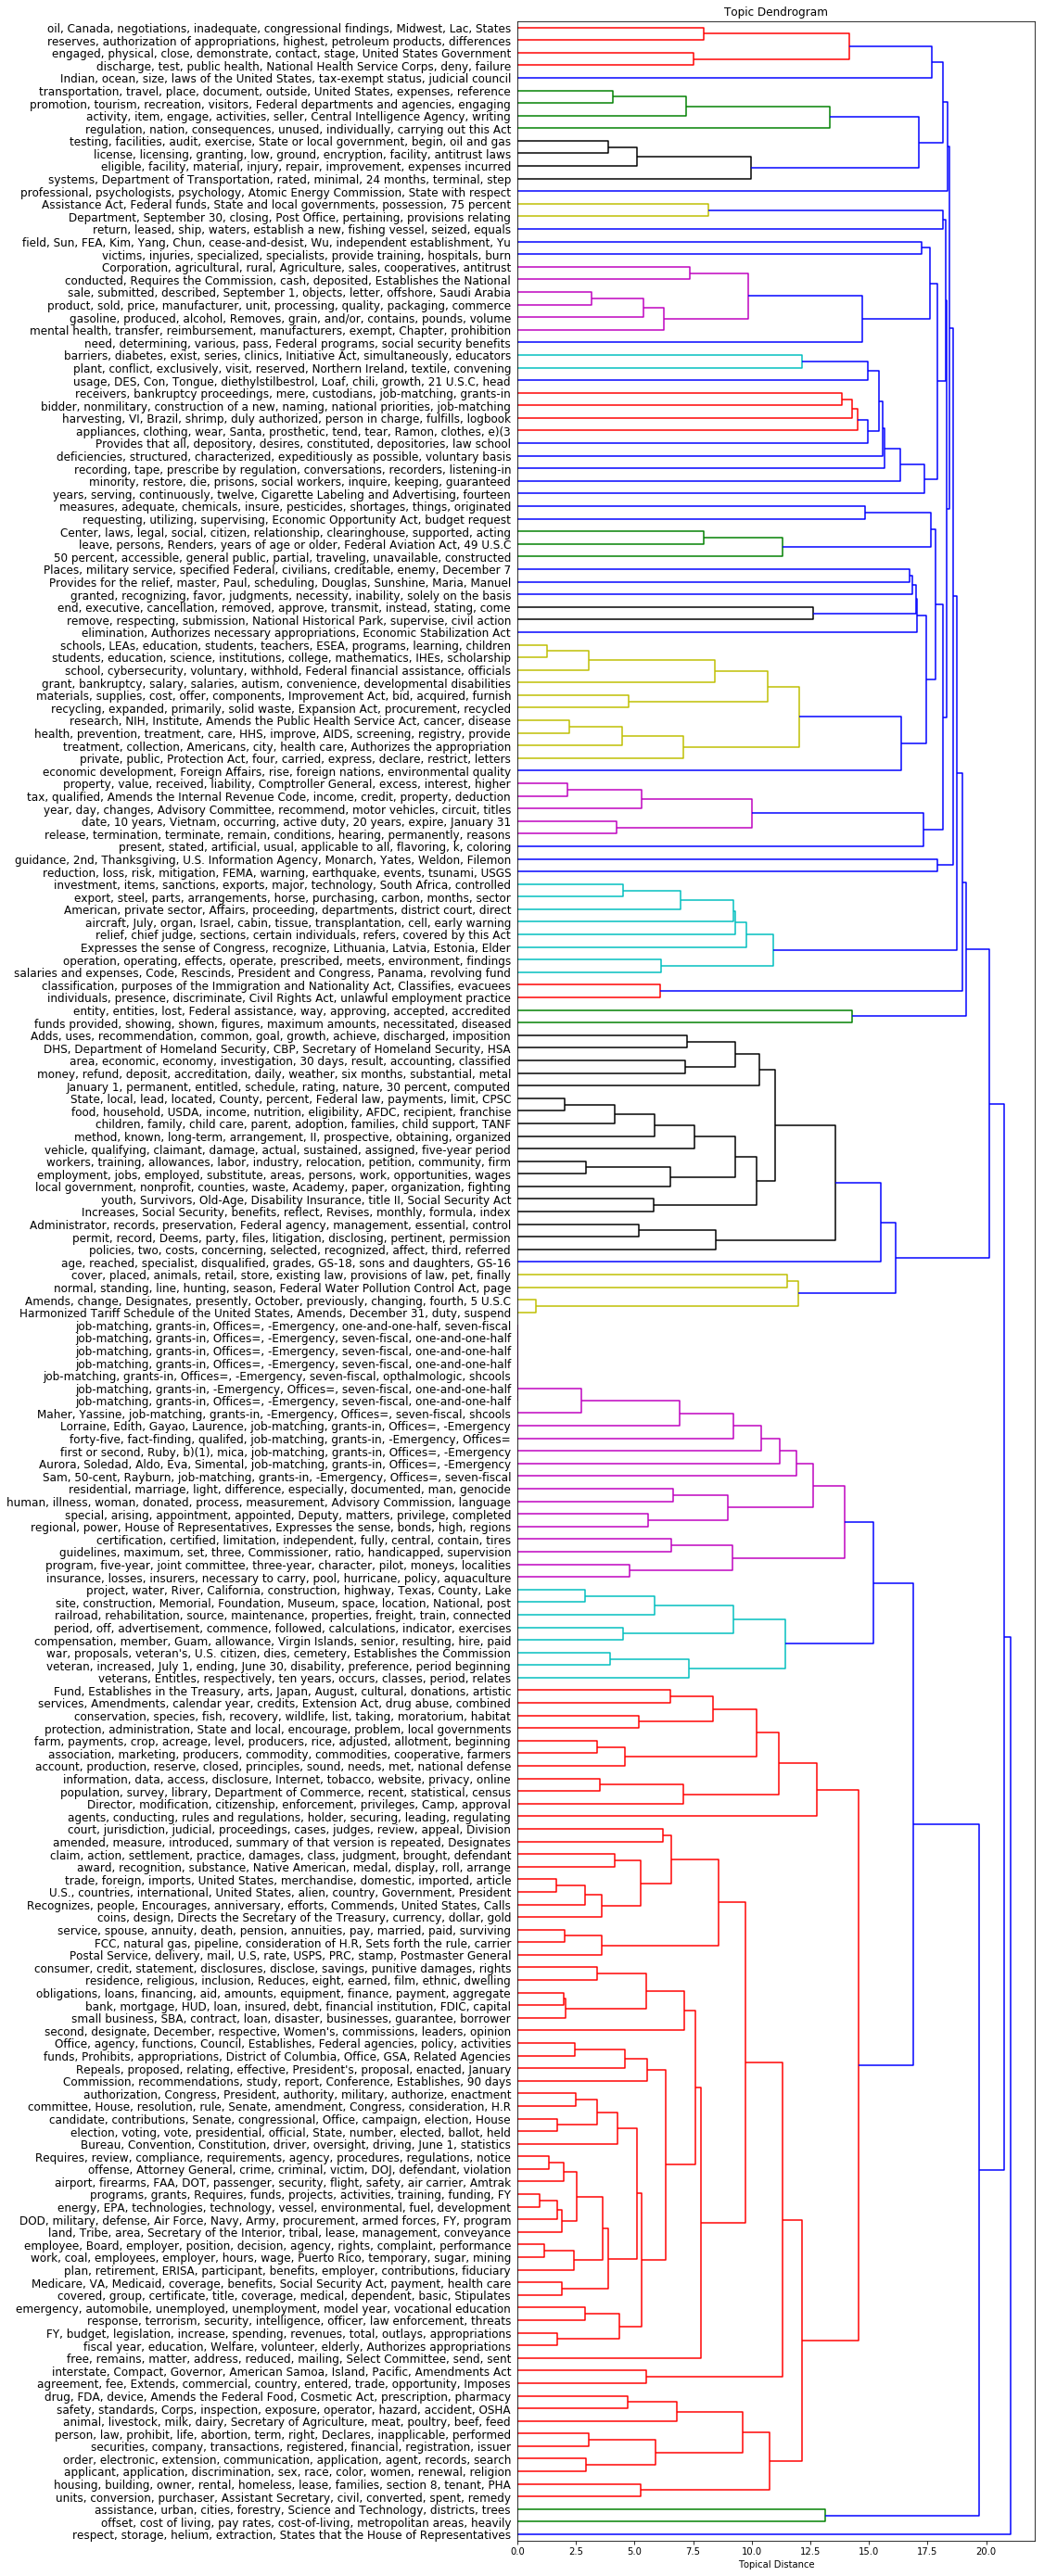

In [10]:
# Plot a dendrogram of the hierarchical clustering of topics
def PlotTopicDendrogram(topicClustering, topicSummaries):    
    numTopics = len(topicSummaries)
    if numTopics != len(topicClustering) + 1:
        print ("Error: Number of topics in topic label set (%d) and topic clustering (%d) are not equal"
               % (numTopics, len(topicClustering) + 1)
              )
        return
    height = int(numTopics/4)
    
    plt.figure(figsize=(10,height))
    plt.title('Topic Dendrogram')
    plt.xlabel('Topical Distance')
    dendrogram(topicClustering, leaf_font_size=12, orientation='right', labels=topicSummaries)
    plt.show()
    return
    
PlotTopicDendrogram(topicClustering,list(topicSummaries['TopicSummary']))


### 2-D Projection of Topics from Topic Similarity Matrix

In [11]:
from sklearn import manifold
from matplotlib.pyplot import figure, show
import numpy as npy
from numpy.random import rand

In [12]:
topicDissimilarity = 1 - topicSimilarity
for i in range(0,numTopics):
    topicDissimilarity[i, i]=0
print(topicDissimilarity)

[[ 0.          0.99407783  0.99972655 ...,  0.99796025  0.99919929
   0.99832878]
 [ 0.99407783  0.          0.9965534  ...,  0.9948107   0.99854797
   0.98613759]
 [ 0.99972655  0.9965534   0.         ...,  0.99877492  0.99939641
   0.99954294]
 ..., 
 [ 0.99796025  0.9948107   0.99877492 ...,  0.          0.99876411
   0.99106888]
 [ 0.99919929  0.99854797  0.99939641 ...,  0.99876411  0.          0.99866429]
 [ 0.99832878  0.98613759  0.99954294 ...,  0.99106888  0.99866429  0.        ]]


In [13]:
mds = manifold.MDS(n_components = 2, dissimilarity="precomputed", random_state=6)
mdsResults = mds.fit(topicDissimilarity)
mdsCoords = mdsResults.embedding_

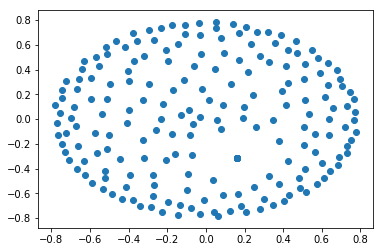

In [14]:
x = mdsCoords[:, 0]
y = mdsCoords[:, 1]

def onpick(event):
    ind = event.ind
    print(str(topicSummaries['TopicSummary'][ind]))

fig, ax = plt.subplots()
col = ax.scatter(x, y, marker = 'o', picker=True)
fig.canvas.mpl_connect('pick_event', onpick)

plt.show()


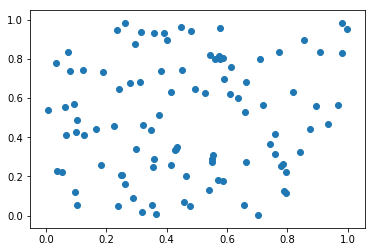

In [15]:
x, y, c, s = rand(4, 100)
def onpick3(event):
    ind = event.ind
    print('onpick3 scatter:', ind, np.take(x, ind), np.take(y, ind))

fig, ax = plt.subplots()
col = ax.scatter(x, y, marker = 'o', picker=True)
fig.canvas.mpl_connect('pick_event', onpick3)

plt.show()

In [ ]:
import os

In [2]:
os.getcwd()

'C:\\Users\\kehuan\\AppData\\Local\\Temp\\azureml_runs\\Document-Collection-Analysis_1505413135474'

In [3]:
from notebooks import winprocess